# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from matplotlib import pyplot

%matplotlib inline

<h1><center>-------------------------------------- Preprocessing --------------------------------------</center></h1>

In [2]:
# read raw files
coffee_data = pd.read_excel('coffee_data.xlsx')
fuel_data = pd.read_excel('fuel_data.xlsx')
weather_data = pd.read_excel('weather_data.xlsx')

### Filter Coffee data

In [3]:
coffee_data['Ngày'] = pd.to_datetime(coffee_data['Ngày'])
# fill up missing dates
coffee_data = coffee_data.set_index('Ngày').resample('D').ffill().reset_index()
coffee_data.head()

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0


### Filter Diesel data

In [4]:
fuel_data["Ngày"] = pd.to_datetime(fuel_data["Ngày"], format="%d.%m.%Y")
# reverse the order
fuel_data = fuel_data[::-1]
fuel_data.head()

,Ngày,Giá Diesel 1 lít
118,2019-01-01,14900.0
117,2019-01-16,14900.0
116,2019-01-31,14900.0
115,2019-02-15,14900.0
114,2019-03-02,15860.0


### Filter Weather Data

In [5]:
weather_data["time"] = pd.to_datetime(weather_data["time"], format="%d.%m.%Y")
weather_data.head()

,time,temperature_mean (°C),precipitation_sum (mm)
0,2018-01-01,21.183332,0.0
1,2018-01-02,21.558332,0.0
2,2018-01-03,22.604166,0.0
3,2018-01-04,23.062494,3.6
4,2018-01-05,23.937500,0.3


<h1><center>-------------------------------------- Calculate Weather --------------------------------------</center></h1>

In [6]:
# 2020
year2020 = (weather_data['time'] >= '2020-1-1') & (weather_data['time'] <= '2020-12-31')
df2 = weather_data.loc[year2020]
# total precipitation
prec2020 = df2["precipitation_sum (mm)"].sum()

# 2021
year2021 = (weather_data['time'] >= '2021-1-1') & (weather_data['time'] <= '2021-12-31')
df2 = weather_data.loc[year2021]
# total precipitation
prec2021 = df2["precipitation_sum (mm)"].sum()

#2022
year2022 = (weather_data['time'] >= '2022-1-1') & (weather_data['time'] <= '2022-12-31')
df2 = weather_data.loc[year2022]
# total precipitation
prec2022 = df2["precipitation_sum (mm)"].sum()

<h1><center>-------------------------------------- Merge Data --------------------------------------</center></h1>

In [7]:
# Merge the dataframes with an outer join
merged_df = pd.merge(coffee_data, fuel_data, left_on='Ngày', right_on='Ngày', how="outer")

# Fill missing dates from both datasets with each other
merged_df.fillna(method='bfill', inplace=True)

In [8]:
# Create new columns
merged_df['Precipitation (mm)'] = ""

In [9]:
# Fill in weather value

# precipitation
merged_df['Precipitation (mm)'] = np.where(merged_df['Ngày'] >= '2021-1-1', prec2020, merged_df['Precipitation (mm)'])
merged_df['Precipitation (mm)'] = np.where(merged_df['Ngày'] >= '2022-1-1', prec2021, merged_df['Precipitation (mm)'])
merged_df['Precipitation (mm)'] = np.where(merged_df['Ngày'] >= '2023-1-1', prec2022, merged_df['Precipitation (mm)'])

In [10]:
# Drop NA rows
merged_df = merged_df.dropna()
data = merged_df

# convert to float
data['Precipitation (mm)'] = data['Precipitation (mm)'].astype(float)

<h1><center>-------------------------------------- Outlier Chart --------------------------------------</center></h1>

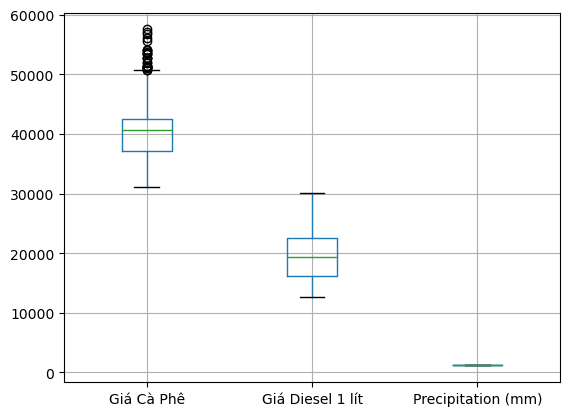

In [11]:
boxplot = data.boxplot()  # draw chart

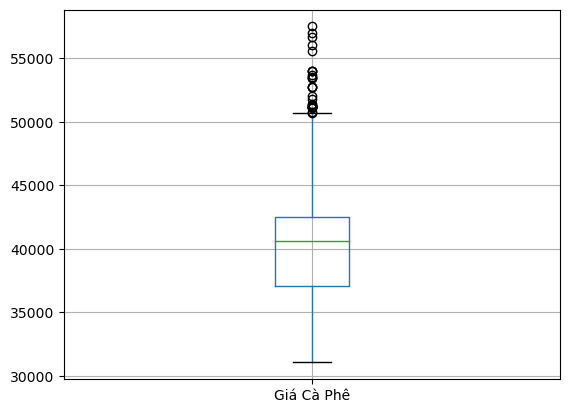

In [12]:
# further inspecting coffee outliers
boxplot = coffee_data.boxplot()  

In [13]:
# detecting outliers
outlier = np.where(coffee_data['Giá Cà Phê'] > 50000)

# removing outliers
data.drop(index=outlier[0], inplace=True)

<h1><center>-------------------------------------- Time Series Chart --------------------------------------</center></h1>

Text(0, 0.5, 'Values')

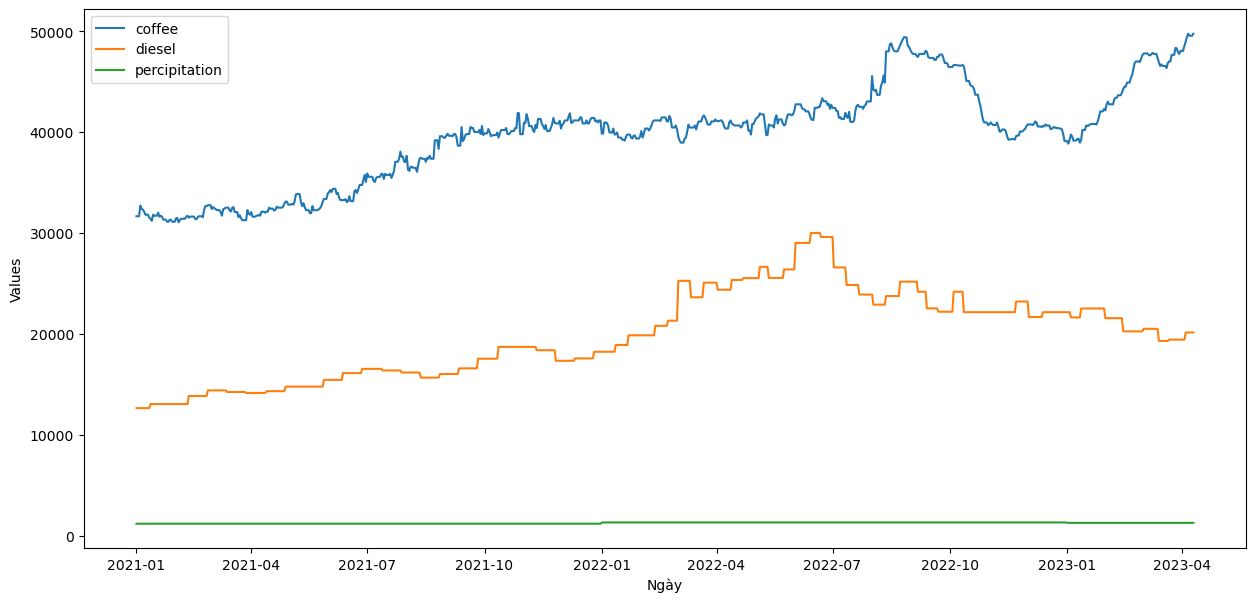

In [14]:
plt.figure(figsize=(15,7))

sns.lineplot(x="Ngày", y="Giá Cà Phê", data=data, label='coffee')
sns.lineplot(x="Ngày", y="Giá Diesel 1 lít", data=data, label='diesel')
sns.lineplot(x="Ngày", y="Precipitation (mm)", data=data, label='percipitation')

# set label
plt.ylabel("Values")

<h1><center>-------------------------------------- Correlation --------------------------------------</center></h1>

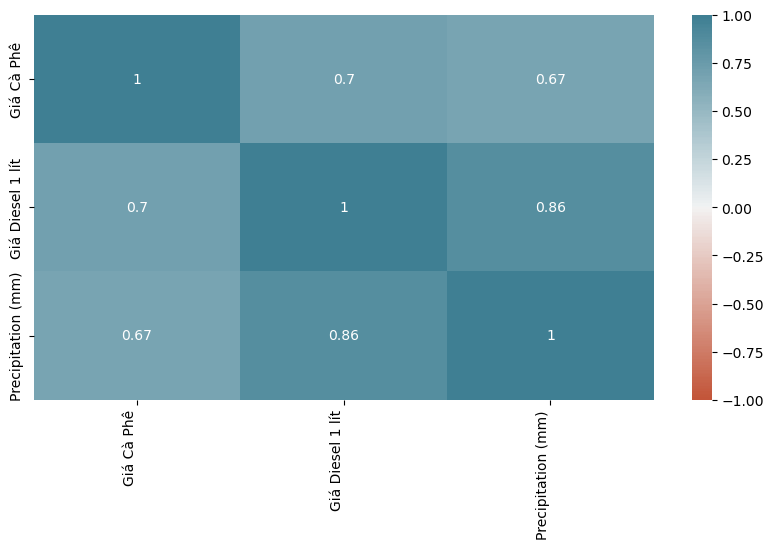

In [15]:
# # Use heatmap to identify correlation between variables
f, ax = plt.subplots(figsize = (10, 5))
corr = data.corr()
ax = sns.heatmap(
    corr, vmin = -1, vmax = 1, center = 0, annot = True,
    cmap = sns.diverging_palette(20, 220, n = 200),
    square = False
)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, horizontalalignment = 'right');

<h1><center>-------------------------------------- Write to file --------------------------------------</center></h1>

In [16]:
# Export the final dataset to excel
data.to_excel('data.xlsx', index=False)